This notebook build a baseline model with light gbm (https://www.kaggle.com/rooshroosh/lightgbm-baseline-1-49-lb/notebook)

In [1]:
import numpy as np
import pandas as pd 
import lightgbm as lgb
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
from sklearn.model_selection import KFold

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
print('train set shape: {}'.format(train.shape))
print('test set shape: {}'.format(test.shape))

train set shape: (4459, 4993)
test set shape: (49342, 4992)


In [4]:
max((train==0).sum(axis=0)), min((train.iloc[:,2:]==0).sum(axis=0))

(4459, 2894)

In [5]:
(train==0).sum(axis=0).sort_values(ascending=False).head(10)

d9a8615f3    4459
3f93a3272    4459
7d7182143    4459
f006d9618    4459
34eff114b    4459
6bda21fee    4459
c1b95c2ec    4459
a7e39d23d    4459
f6fac27c8    4459
d98484125    4459
dtype: int64

In [6]:
sum((train==0).sum(axis=0)==4459)

256

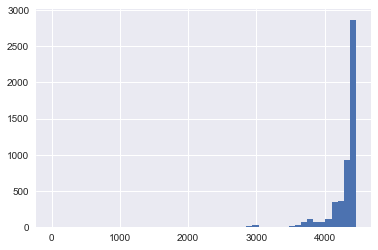

In [7]:
(train==0).sum(axis=0).hist(bins=50)
plt.show()

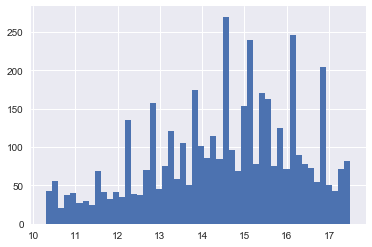

In [8]:
col = np.random.randint(low=2, high=4993, size=1)
col = 'c5a231d81'
col = 'target'
np.log(train.loc[:,col]+1).hist(bins=50)

In [9]:
Y_train = np.log(train.target+1)
train.drop(['target'], axis=1, inplace=True)

In [10]:
test_ID = test.ID
test.drop(['ID'], axis=1, inplace=True)

train_ID = train.ID
train.drop(['ID'], axis=1, inplace=True)

In [11]:
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 8,
    'num_leaves': 32,  # 63, 127, 255
    'feature_fraction': 0.8, # 0.1, 0.01
    'bagging_fraction': 0.8,
    'learning_rate': 0.01, #0.00625,#125,#0.025,#05,
    'verbose': 1
}

In [12]:
Y_target = []
kf = KFold(n_splits=5, random_state=8668)
for fold_id,(train_idx, val_idx) in enumerate(kf.split(train)):
    print('FOLD:',fold_id)
    X_train = train.values[train_idx]
    y_train = Y_train.values[train_idx]
    X_valid = train.values[val_idx]
    y_valid =  Y_train.values[val_idx]
    
    
    lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=train.columns.tolist(),
    #             categorical_feature = categorical
                         )

    lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=train.columns.tolist(),
    #             categorical_feature = categorical
                         )

    modelstart = time.time()
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=30000,
        valid_sets=[lgtrain, lgvalid],
        valid_names=['train','valid'],
        early_stopping_rounds=100,
        verbose_eval=100
    )
    
    test_pred = lgb_clf.predict(test.values)
    Y_target.append(np.exp(test_pred)-1)
    print('fold finish after', time.time()-modelstart)

FOLD: 0
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.45828	valid's rmse: 1.51756
[200]	train's rmse: 1.31146	valid's rmse: 1.45778
[300]	train's rmse: 1.23213	valid's rmse: 1.43468
[400]	train's rmse: 1.18764	valid's rmse: 1.42788
[500]	train's rmse: 1.15144	valid's rmse: 1.42326
[600]	train's rmse: 1.12192	valid's rmse: 1.42134
[700]	train's rmse: 1.09884	valid's rmse: 1.42019
[800]	train's rmse: 1.07732	valid's rmse: 1.41926
[900]	train's rmse: 1.05726	valid's rmse: 1.41914
[1000]	train's rmse: 1.03871	valid's rmse: 1.4187
[1100]	train's rmse: 1.02106	valid's rmse: 1.41848
Early stopping, best iteration is:
[1048]	train's rmse: 1.02967	valid's rmse: 1.41818
fold finish after 28.963394165039062
FOLD: 1
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.44929	valid's rmse: 1.57732
[200]	train's rmse: 1.3076	valid's rmse: 1.51834
[300]	train's rmse: 1.22607	valid's rmse: 1.49822
[400]	train's rmse: 1.18118	valid's

Example plot of feature importance

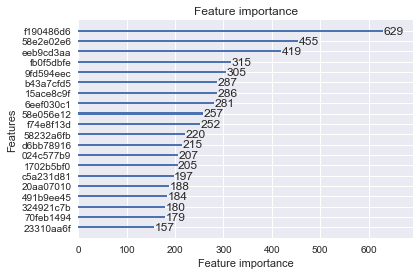

In [13]:
ax = lgb.plot_importance(lgb_clf, max_num_features=20)
plt.show()

In [30]:
gain = lgb_clf.feature_importance('gain')
feat_importance = pd.DataFrame({'feature':lgb_clf.feature_name(), 'split':lgb_clf.feature_importance('split'), 'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
feat_importance.to_csv('../output/sub_lgb_bl_fe.csv', index=False)
feat_importance.head()

,feature,gain,split
4358,f190486d6,12.508257,629
3660,eeb9cd3aa,5.662622,419
2500,58e2e02e6,3.781215,455
2755,9fd594eec,3.012605,305
4243,15ace8c9f,2.188851,286


In [15]:
Y_target = np.array(Y_target)
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = Y_target.mean(axis=0)
sub.to_csv('../output/sub_lgb_baseline.csv', index=False)